In [64]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import torch
from matplotlib import patches
from tqdm import tqdm
import scipy
import statistics
from matplotlib.ticker import MaxNLocator
import ast
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu

In [58]:
new_names = {'en': 'EN Declarative (H)',
'en-r-1-subordinate': 'EN Subordinate (H)',
'en-r-2-passive': 'EN Passive (H)',
'en-u-1-negation': 'EN Negation (L)',
'en-u-2-inversion':'EN Inversion (L)',
# 'en-u-3-qsubordinate':'EN qsubordinate (L)',
'en-u-4-wh':'EN Wh- word (L)',
# 'it':'$IT_S$ Declarative (H)',
# 'it-r-1-null_subject':'$IT_S$ null subject (H)',
# 'it-r-2-passive':'$IT_S$ passive (H)',
# 'it-r-3-subordinate':'$IT_S$ subordinate (H)',
# 'it-u-1-negation':'$IT_S$ negative token (L)',
# 'it-u-2-invert':'$IT_S$ inverted (L)',
# 'it-u-3-gender':'$IT_S$ gender determiner (L)',
'ita':'IT Declarative (H)',
# 'ita-r-1-null_subject':'IT null subject (H)',
'ita-r-3-passive':'IT Passive (H)',
'ita-r-2-subordinate':'IT Subordinate (H)',
'ita-u-1-negation':'IT Negation (L)',
'ita-u-2-invert':'IT Inversion (L)',
'ita-u-3-gender':'IT gender agreement (L)',
'jap-r-1-sov':'JP Declarative (H)',
'jap-r-2-passive':'JP Passive (H)',
'jap-r-3-subordinate':'JP Subordinate (H)',
'jap-u-1-negation':'JP Negation(L)',
'jap-u-2-invert':'JP Inversion (L)',
'jap-u-3-past-tense':'JP past-tense (L)',
# 'jp-r-1-sov':'$JP_S$ declarative (H)',
# 'jp-r-2-passive':'$JP_S$ passive (H)',
# 'jp-r-3-subordinate':'$JP_S$ subordinate (H)',
# 'jp-u-1-negation':'$JP_S$ negative token (L)',
# 'jp-u-2-invert':'$JP_S$ inverted (L)',
# 'jp-u-3-past-tense':'$JP_S$ incorrect past tense (L)'
}

In [38]:
colors = {
    'Watermelon Pink': '#FC6C85',
    'Flamingo Pink': '#FC8EAC',
    'Coral Pink': '#F88379',
    'Hot Pink': '#FF69B4',
    'Deep Pink': '#FF1493',
    'Watermelon Green': '#8DB600',
    'Mint Green': '#98FF98',
    'Jade Green': '#00A86B',
    'Fern Green': '#4F7942',
    'Sea Green': '#2E8B57'
}

real_color = '#007FFF'
unreal_color = '#E55451'
mixed_color = '#6300A9'

## Training accuracies

In [40]:
mistral_base = pd.read_csv('/mnt/align4_drive/arunas/broca/mistral/experiments/10-strip/acc.csv')
# mistral_uofi_reals = pd.read_csv('/mnt/align4_drive/arunas/broca/mistral/experiments/10-uofi-real/acc.csv')
# mistral_uofi_unreals = pd.read_csv('/mnt/align4_drive/arunas/broca/mistral/experiments/10-uofi-unreal/acc.csv')
llama_base = pd.read_csv('/mnt/align4_drive/arunas/broca/llama/experiments/10/acc.csv')

mistral+10-strip+en Chi-square statistic: 408.112566355294, p-value: 9.440056282928054e-91
TtestResult(statistic=21.615789102531057, pvalue=4.730803913305592e-97, df=3316.0)
mistral+10-strip+ita Chi-square statistic: 147.66578666925014, p-value: 5.612923238459959e-34
TtestResult(statistic=12.469112289493427, pvalue=6.593091558669743e-35, df=3316.0)
mistral+10-strip+jap Chi-square statistic: 48.065898537322894, p-value: 4.121322966639702e-12
TtestResult(statistic=7.024303253083327, pvalue=2.599107480642704e-12, df=3316.0)
[0.9166666666666667, 0.8133333333333334, 0.83] [0.6233333333333333, 0.6266666666666667, 0.73]


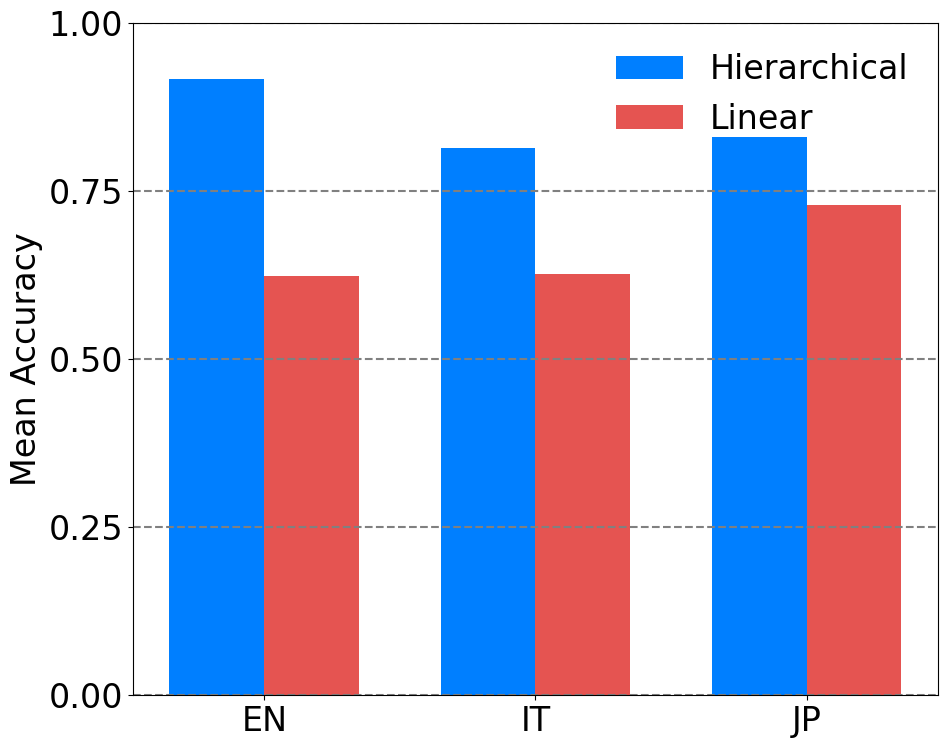

llama+10+en Chi-square statistic: 338.284955071501, p-value: 1.5079245440411408e-75
TtestResult(statistic=19.447129523367924, pvalue=7.365388410786579e-80, df=3316.0)
llama+10+ita Chi-square statistic: 120.3777738445718, p-value: 5.229133232570459e-28
TtestResult(statistic=11.211447802874025, pvalue=1.1664890074659199e-28, df=3316.0)
llama+10+jap Chi-square statistic: 171.3180219286463, p-value: 3.8133239348675e-39
TtestResult(statistic=13.481515042361265, pvalue=2.2816408922016647e-40, df=3316.0)
[0.8466666666666667, 0.7433333333333333, 0.9450000000000001] [0.55, 0.5599999999999999, 0.675]


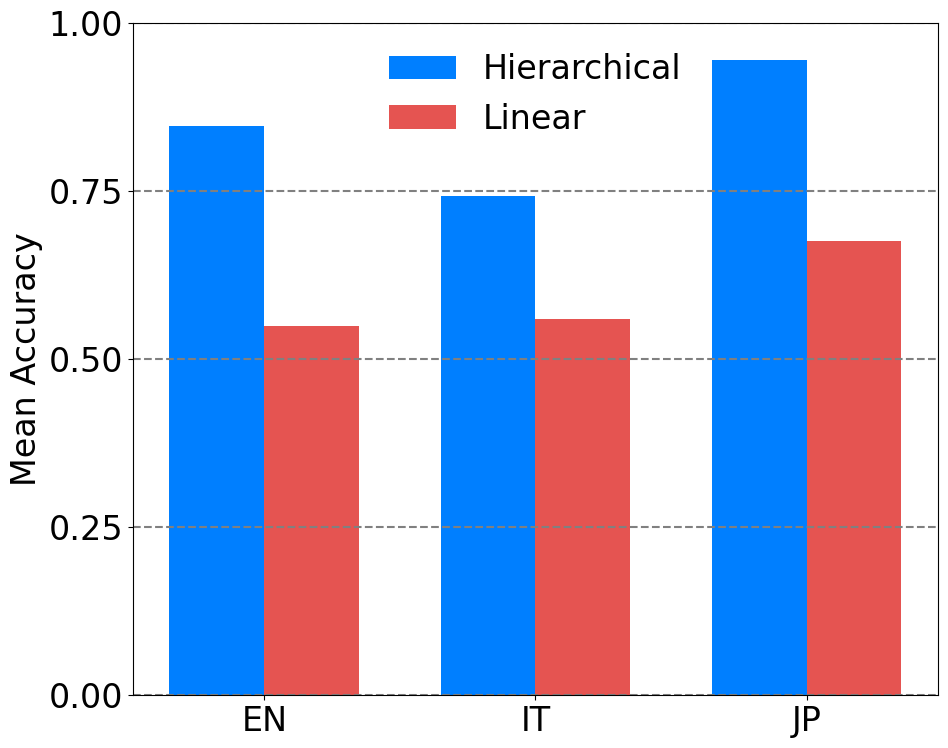

In [114]:
def get_stat_sig(MODEL_NAME, expt, lang):
    reals = []
    unreals = []
    for key in new_names.keys():
        if (lang != key[:len(lang)]):
            continue;
        langFile = pd.read_csv(f'/mnt/align4_drive/arunas/broca/{MODEL_NAME}/experiments/{expt}/{key}.csv')
        langFile['accuracy'] = langFile.apply(lambda row: row['prediction'] == row['gold'], axis=1)
        if ('-u-' in key ):
            unreals += list(langFile['accuracy'])
        else:
            reals += list(langFile['accuracy'])

    contingency_table = [[reals.count(True), reals.count(False)],
                     [unreals.count(True), unreals.count(False)]]
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    print(f"{MODEL_NAME}+{expt}+{lang} Chi-square statistic: {chi2}, p-value: {p}")

    # mean_accuracy = pd.read_csv(f'/mnt/align4_drive/arunas/broca/{MODEL_NAME}/experiments/{expt}/acc.csv')
    # reals = list(mean_accuracy[mean_accuracy['lang'].str.contains("-u-")]['accuracy'])
    # unreals = list(mean_accuracy[mean_accuracy['lang'].str.contains("-u-")]['accuracy'])

    print(stats.ttest_ind(reals, unreals))
    
def get_few_shot_accuracy(df, MODEL_NAME, expt):
    get_stat_sig(MODEL_NAME, expt, 'en')
    get_stat_sig(MODEL_NAME, expt, 'ita')
    get_stat_sig(MODEL_NAME, expt, 'jap')
    # Sample data
    plt.rcParams.update({'font.size': 24})
    lang = ['EN', 'ITA', 'JAP']
    reals_base = [statistics.mean(list(df[df['lang'].isin(filter(lambda val: l.lower() in val[:len(l)] if not '-u-' in val else 0, list(df['lang'])))]['accuracy'])) for l in lang]
    unreals_base = [statistics.mean(list(df[df['lang'].isin(filter(lambda val: l.lower() in val[:len(l)] if '-u-' in val else 0, list(df['lang'])))]['accuracy'])) for l in lang]
    
    # Number of categories
    n = len(lang)
    
    # Create bar plot
    fig, ax = plt.subplots(figsize=(10,8))
    
    bar_width = 0.35
    index = np.arange(n)
    
    # Plotting the bar plots
    ax.bar(index, reals_base, bar_width, label='Hierarchical', color=[real_color])
    ax.bar(index + bar_width, unreals_base, bar_width, label='Linear', color=[unreal_color])
    plt.grid(True, which='major', axis='y', linestyle='--', linewidth=1.5, color='gray', alpha=1)
    # Add labels, title, and legend
    # ax.set_xlabel('Language')
    ax.set_ylabel('Mean Accuracy')
    ax.set_ylim(0,1)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
    # ax.set_title('Few-shot accuracy')
    ax.set_xticks(index + bar_width/2)
    ax.set_xticklabels(['EN', 'IT', 'JP'])
    ax.legend(frameon=False)
    plt.tight_layout()
    fig.savefig(f'{MODEL_NAME}-few-shot-accuracy.png')
    # Display the plot
    print(reals_base, unreals_base)
    plt.show()

get_few_shot_accuracy(mistral_base, 'mistral', '10-strip')
get_few_shot_accuracy(llama_base, 'llama', '10')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


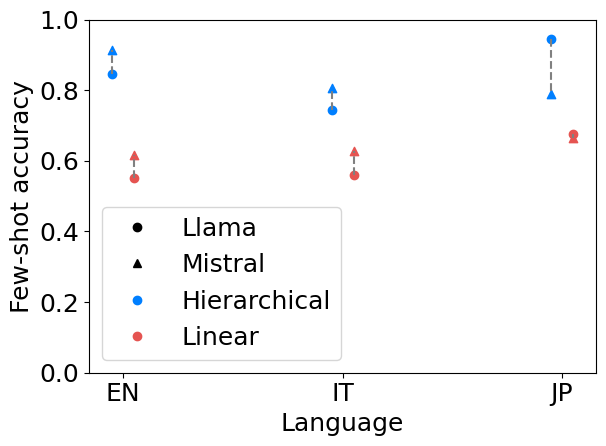

In [179]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 18})
# Plot settings
real_color = '#007FFF'  # Blue
unreal_color = '#E55451'  # Red
l_marker = 'o'
m_marker = '^'

# Create figure and axis
fig, ax = plt.subplots()

# Plot Llama data
for i in range(len(l_reals_base)):
    ax.scatter(i-0.05, l_reals_base[i], color=real_color, marker=l_marker)
    ax.scatter(i-0.05, m_reals_base[i], color=real_color, marker=m_marker)
    ax.scatter(i+0.05, l_unreals_base[i], color=unreal_color, marker=l_marker)
    ax.scatter(i+0.05, m_unreals_base[i], color=unreal_color, marker=m_marker)
    ax.plot([i-0.05, i-0.05], [l_reals_base[i], m_reals_base[i]], color='gray', linestyle='--')
    ax.plot([i+0.05, i+0.05], [l_unreals_base[i], m_unreals_base[i]], color='gray', linestyle='--')

# Add labels and legend
ax.set_xlabel('Language')
ax.set_ylabel('Few-shot accuracy')
# ax.set_title('Real vs Unreal Accuracies for Llama and Mistral Models')
ax.set_xticks(range(len(l_reals_base)), labels=['EN', 'IT', 'JP'])
ax.legend()
ax.set_ylim(0,1)

llama_proxy = plt.Line2D([0], [0], linestyle='none', marker=l_marker, color='k', label='Llama')
mistral_proxy = plt.Line2D([0], [0], linestyle='none', marker=m_marker, color='k', label='Mistral')
real_proxy = plt.Line2D([0], [0], linestyle='none', marker='o', color=real_color, label='Hierarchical')
unreal_proxy = plt.Line2D([0], [0], linestyle='none', marker='o', color=unreal_color, label='Linear')

ax.legend(handles=[llama_proxy, mistral_proxy, real_proxy, unreal_proxy])
plt.tight_layout()
fig.savefig('few-shot-accuracy.png')
# Show plot
plt.show()


In [ ]:
# merged = pd.merge(mistral, llama, on='type', how='outer')
# merged = merged.rename(columns={'accuracy_x': 'mistral', 'accuracy_y': 'llama'})
# merged.index=merged['type']
# merged.drop( ['type'], inplace=True, axis=1)
# merged = merged.T
# merged.loc[merged.index=='llama'].values
# m_colors = { 'r': '#87CEFA', 'u': '#FFB6A0' }
# l_colors = { 'r': '#007FFF', 'u': '#E55451' }
# bp_colors = []
# real_indices = []
# mistral_real = []
# llama_real = []
# unreal_indices = []
# mistral_unreal = []
# llama_unreal = []

# for idx, i in enumerate(merged.columns):
#     if ('-r-' in i) or (not ('-' in i)):
#         bp_colors.append(m_colors['r'])
#         bp_colors.append(l_colors['r'])
#         real_indices.append(idx)
#         mistral_real.append(merged.loc[merged.index=='mistral'][i].item())
#         llama_real.append(merged.loc[merged.index=='llama'][i].item())
#     else:
#         bp_colors.append(m_colors['u'])
#         bp_colors.append(l_colors['u'])
#         unreal_indices.append(idx)
#         mistral_unreal.append(merged.loc[merged.index=='mistral'][i].item())
#         llama_unreal.append(merged.loc[merged.index=='llama'][i].item())

# # counts =  [ {'r': 3, 'u':4}, {'r': 4, 'u':3}, {'r': 4, 'u':3}, {'r': 2, 'u':2}, {'r': 3, 'u':3}]
# #             #en               #it              #ita             #jap            #jp
# counts =  [ {'r': 3, 'u':4}, {'r': 4, 'u':3}, {'r': 3, 'u':3}]
#             #en               #ita              #jap
# llama_avg_accuracies = { 'real': [], 'unreal': [] }
# mistral_avg_accuracies = { 'real': [], 'unreal': [] }

# fig = plt.figure(figsize=(10, 5), dpi=80) 
# plt.bar(np.array(real_indices)-0.125, llama_real, color=['#007FFF'], width=0.25, label='Llama-70B (P)')
# plt.bar(np.array(real_indices)+0.125, mistral_real, color=['#87CEFA'], width=0.25, label='Mistral-7B (P)')
# plt.bar(np.array(unreal_indices)-0.125, llama_unreal, color=['#E55451'], width=0.25, label='Llama-70B (I)')
# plt.bar(np.array(unreal_indices)+0.125, mistral_unreal, color=['#FFB6A0'], width=0.25, label='Mistral-7B (I)')
# plt.xticks(np.arange(len(merged.columns)), labels=[new_names[col] for col in merged.columns], rotation=90)
# plt.ylim(0, 1.2)
# for idx, count in enumerate(counts):
#     if (idx == 0):
#         start = 0
#     else:
#         start = sum([val['r'] for i, val in enumerate(counts) if i < idx])
#     stop = start + counts[idx]['r']
#     print('real', idx, start, stop, counts)
#     llama_avg_accuracies['real'].append(sum(llama_real[start:stop])/count['r'])
#     mistral_avg_accuracies['real'].append(sum(mistral_real[start:stop])/count['r'])

#     start = 0
#     if (idx == 0):
#         start = 0
#     else:
#         start += sum([val['u'] for i, val in enumerate(counts) if i < idx])
#     stop = start + counts[idx]['u']
#     print('unreal', idx, start, stop, counts)
#     llama_avg_accuracies['unreal'].append(sum(llama_unreal[start:stop])/count['u'])
#     mistral_avg_accuracies['unreal'].append(sum(mistral_unreal[start:stop])/count['u'])

# # print(llama_avg_accuracies, mistral_avg_accuracies)
# for idx in range(len(llama_avg_accuracies['real'])):
#     if (idx == 0):
#         start = 0
#         stop = counts[idx]['r'] + counts[idx]['u']
#     else:
#         start = sum([counts[m]['r'] + counts[m]['u'] for m in range(len(llama_avg_accuracies['real'])) if m < idx])
#         stop = start + counts[idx]['r'] + counts[idx]['u']        

#     plt.plot([start - 0.5, stop - 0.5], [llama_avg_accuracies['real'][idx], llama_avg_accuracies['real'][idx]], linestyle='-', linewidth=2, color='#007FFF')
#     plt.plot([start - 0.5, stop - 0.5], [llama_avg_accuracies['real'][idx], llama_avg_accuracies['real'][idx]], linestyle='--', linewidth=0.5, color='black')
    
#     plt.plot([start - 0.5 , stop - 0.5], [mistral_avg_accuracies['real'][idx], mistral_avg_accuracies['real'][idx]], linestyle='-', linewidth=2, color='#87CEFA')
#     plt.plot([start - 0.5, stop - 0.5], [mistral_avg_accuracies['real'][idx], mistral_avg_accuracies['real'][idx]], linestyle='--', linewidth=0.5, color='black')
    
#     plt.plot([start - 0.5, stop - 0.5], [llama_avg_accuracies['unreal'][idx], llama_avg_accuracies['unreal'][idx]], linestyle='-', linewidth=2, color='#E55451')
#     plt.plot([start - 0.5, stop - 0.5], [llama_avg_accuracies['unreal'][idx], llama_avg_accuracies['unreal'][idx]], linestyle='--', linewidth=0.5, color='black')
    
#     plt.plot([start - 0.5, stop - 0.5], [mistral_avg_accuracies['unreal'][idx], mistral_avg_accuracies['unreal'][idx]], linestyle='-', linewidth=2, color='#FFB6A0')
#     plt.plot([start - 0.5, stop - 0.5], [mistral_avg_accuracies['unreal'][idx], mistral_avg_accuracies['unreal'][idx]], linestyle='--', linewidth=0.5, color='black')

# print(llama_avg_accuracies, mistral_avg_accuracies)

# plt.legend(ncol=4)
# plt.xlim(left=-0.5, right=30.5)
# plt.xlabel('Grammar Type')
# plt.ylabel('Accuracy')
# plt.axvline(x=6.5, linestyle='--', linewidth=1, color='black')
# plt.axvline(x=13.5, linestyle='--', linewidth=1, color='black')
# plt.axvline(x=20.5, linestyle='--', linewidth=1, color='black')
# plt.axvline(x=24.5, linestyle='--', linewidth=1, color='black')
# fig.tight_layout()
# # plt.savefig('/mnt/align4_drive/arunas/broca/mistral/experiments/new-prompt-prologue-random-seed/model-accuracies.png')
# # plt.savefig('/mnt/align4_drive/arunas/broca/llama/experiments/new-prompt-prologue-random-seed/model-accuracies.png')

In [ ]:
# counts =  [ {'r': 3, 'u':4}, {'r': 4, 'u':3}, {'r': 4, 'u':3}, {'r': 2, 'u':2}, {'r': 3, 'u':3}]
#             #en               #it              #ita             #jap            #jp
# llama_avg_accuracies = { 'real': [], 'unreal': [] }
# mistral_avg_accuracies = { 'real': [], 'unreal': [] }

# for idx, item in enumerate(counts):
#     start_idx = [val['r'] + val['u'] for i in enumerate(counts) if i < idx] or 0
#     stop_idx = start_idx + counts['r']
#     llama_avg_accuracies['real'].append(sum(llama_reals[start_idx:stop_idx])/counts['r'])
#     mistral_avg_accuracies['real'].append(sum(mistral_reals[start_idx:stop_idx])/counts['r'])

#     start_idx = [val['r'] + val['u'] for i in enumerate(counts) if i < idx] or 0
#     start_idx += counts['r']
#     stop_idx = start_idx + counts['u']

#     llama_avg_accuracies['unreal'].append(sum(llama_unreals[start_idx:stop_idx])/counts['u'])
#     mistral_avg_accuracies['unreal'].append(sum(mistral_unreals[start_idx:stop_idx])/counts['r'])



## Surprisals

In [138]:
wcolors = [colors['Watermelon Green'], colors['Watermelon Pink']]

6532 5964 en TtestResult(statistic=-2.1759315914428248, pvalue=0.029579050460182485, df=12494.0)
6210 5315 ita TtestResult(statistic=-0.2419104294524739, pvalue=0.8088538734146746, df=11523.0)
1704 1704 jap TtestResult(statistic=-0.7368466715061897, pvalue=0.46126634774185815, df=3406.0)


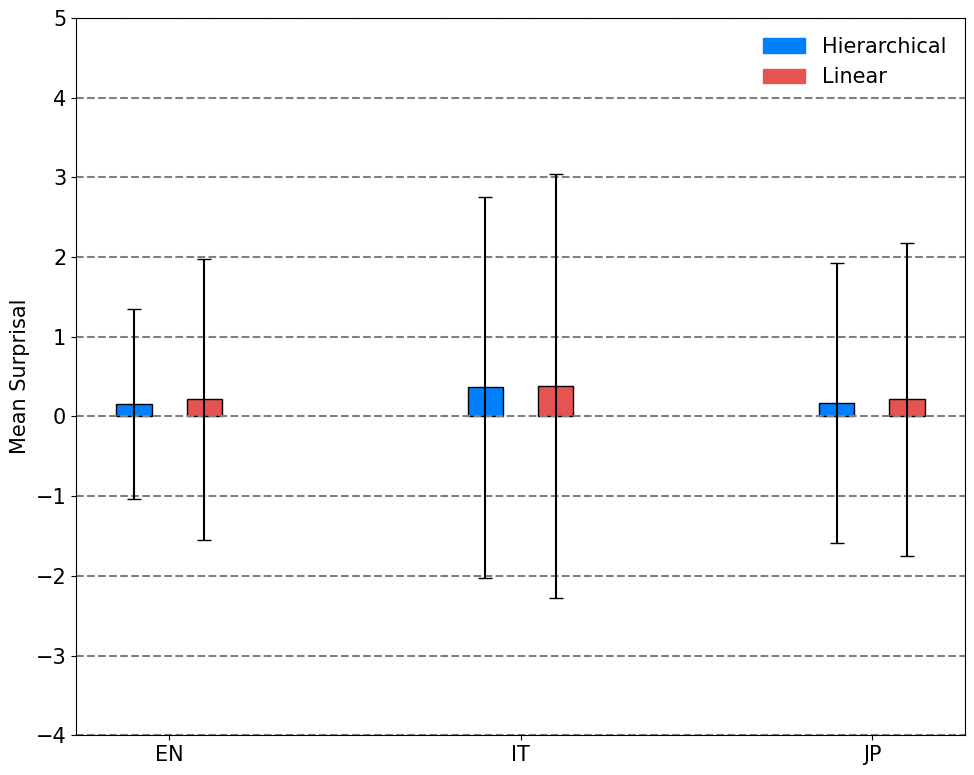

In [154]:
plt.rcParams.update({'font.size': 15})
def get_surps(cols):
    ur_surps = []
    g_surps = []
    for col in cols:
        f = pd.read_csv(f'/mnt/align4_drive/arunas/broca/mistral/experiments/10-strip/{col}.csv')
        if ('-u-' in col):
            for idx, row in f[(f['type'] == col) & (f['gold'] == 'Yes')].iterrows():
                myList = []
                for i in list(ast.literal_eval(row['surprisal'])):
                    myList.append(i[1])
                ur_surps.append(myList)
        else:
            for idx, row in f[(f['type'] == col) & (f['gold'] == 'Yes')].iterrows():
                myList = []
                for i in list(ast.literal_eval(row['surprisal'])):
                    myList.append(i[1])
                g_surps.append(myList)
    allg_surps = np.array([i for s in g_surps for i in s])
    allug_surps = np.array([i for s in ur_surps for i in s])

    print(len(allg_surps), len(allug_surps), cols[0][:3], stats.ttest_ind(allg_surps, allug_surps))
    return sorted(allg_surps), sorted(allug_surps)

en_real, en_unreal = get_surps(['en', 'en-r-1-subordinate', 'en-r-2-passive', 'en-u-1-negation', 'en-u-2-inversion', 'en-u-4-wh'])
ita_real, ita_unreal = get_surps(['ita', 'ita-r-2-subordinate', 'ita-r-3-passive', 'ita-u-1-negation', 'ita-u-2-invert', 'ita-u-3-gender'])
jap_real, jap_unreal = get_surps(['jap-r-1-sov','jap-r-2-passive', 'jap-r-3-subordinate','jap-u-1-negation','jap-u-2-invert', 'jap-u-3-past-tense'])
reals = [en_real, ita_real, jap_real]
unreals = [en_unreal, ita_unreal, jap_unreal]

positions = np.arange(1, len(reals) + 1)

plt.figure(figsize=(10,8))
# for i in range(len(reals)):
    # bp = plt.boxplot([reals[i], unreals[i]], positions=[positions[i], positions[i] + 0.4], 
    #             widths=0.4, autorange=True, patch_artist=True, showfliers=False, vert=True, showmeans=True)
    # for patch, color in zip(bp['boxes'], [real_color, unreal_color]):
    #     patch.set_facecolor(color)

    # for mean, color in zip([bp['means'][0], bp['means'][1]], [real_color, unreal_color]):
    #     mean.set(markerfacecolor=color, marker='o', markersize=10, markeredgecolor="black")
plt.bar(positions, [statistics.mean(real_dist) for real_dist in reals], yerr=[statistics.stdev(real_dist) for real_dist in reals], width=0.1, capsize=5, color=real_color, alpha=1, edgecolor='black')
plt.bar(positions + 0.2, [statistics.mean(unreal_dist) for unreal_dist in unreals], yerr=[statistics.stdev(unreal_dist) for unreal_dist in unreals], width=0.1, capsize=5, color=unreal_color, alpha=1, edgecolor='black')

# plt.xlabel("Language")
plt.xticks(positions + 0.1, ['EN', 'IT', 'JP'])
plt.ylabel("Mean Surprisal")
plt.ylim(-4,5)
# plt.ylim(0,1)
plt.grid(True, which='major', axis='y', linestyle='--', linewidth=1.5, color='gray', alpha=1)
# plt.ylim(0,1)
# plt.axvline(x=1.75, color='black', linestyle='--', linewidth=0.5)
# plt.axvline(x=2.75, color='black', linestyle='--', linewidth=0.5)
plt.tight_layout()
legend_handles = [plt.Rectangle((0,0),1,1, color=real_color), plt.Rectangle((0,0),1,1, color=unreal_color)]
plt.legend(legend_handles, ['Hierarchical', 'Linear'], frameon=False)
plt.savefig('mistral-surprisal.png')

6532 5964 en TtestResult(statistic=-1.5844474433258782, pvalue=0.11311724171462967, df=12494.0)
6210 5315 ita TtestResult(statistic=-0.3335007143194965, pvalue=0.7387624184740181, df=11523.0)
1704 1704 jap TtestResult(statistic=0.10331465570667998, pvalue=0.9177193266851487, df=3406.0)


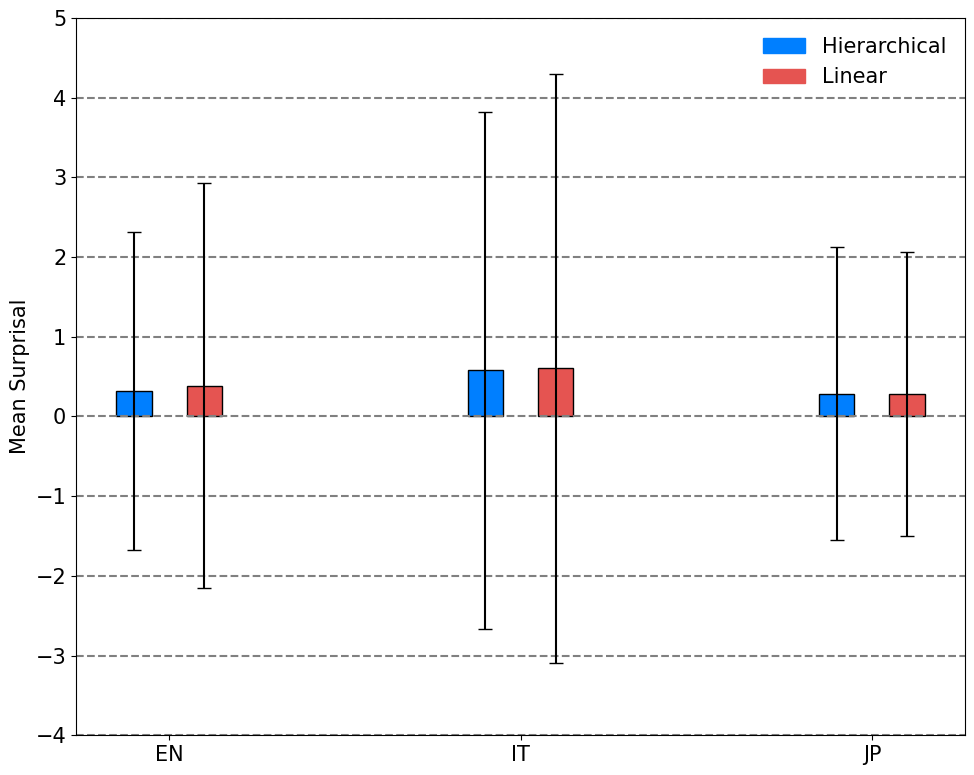

In [155]:
def get_surps(cols):
    ur_surps = []
    g_surps = []
    for col in cols:
        f = pd.read_csv(f'/mnt/align4_drive/arunas/broca/llama/experiments/10/{col}.csv')
        if ('-u-' in col):
            for idx, row in f[(f['type'] == col) & (f['gold'] == 'Yes')].iterrows():
                myList = []
                for i in list(ast.literal_eval(row['surprisal'])):
                    myList.append(i[1])
                ur_surps.append(myList)
        else:
            for idx, row in f[(f['type'] == col) & (f['gold'] == 'Yes')].iterrows():
                myList = []
                for i in list(ast.literal_eval(row['surprisal'])):
                    myList.append(i[1])
                g_surps.append(myList)
    allg_surps = np.array([i for s in g_surps for i in s])
    allug_surps = np.array([i for s in ur_surps for i in s])

    print(len(allg_surps), len(allug_surps), cols[0][:3], stats.ttest_ind(allg_surps, allug_surps))
    return sorted(allg_surps), sorted(allug_surps)

en_real, en_unreal = get_surps(['en', 'en-r-1-subordinate', 'en-r-2-passive', 'en-u-1-negation', 'en-u-2-inversion', 'en-u-4-wh'])
ita_real, ita_unreal = get_surps(['ita', 'ita-r-2-subordinate', 'ita-r-3-passive', 'ita-u-1-negation', 'ita-u-2-invert', 'ita-u-3-gender'])
jap_real, jap_unreal = get_surps(['jap-r-1-sov','jap-r-2-passive', 'jap-r-3-subordinate','jap-u-1-negation','jap-u-2-invert', 'jap-u-3-past-tense'])
reals = [en_real, ita_real, jap_real]
unreals = [en_unreal, ita_unreal, jap_unreal]

positions = np.arange(1, len(reals) + 1)

plt.figure(figsize=(10,8))
# for i in range(len(reals)):
    # bp = plt.boxplot([reals[i], unreals[i]], positions=[positions[i], positions[i] + 0.4], 
    #             widths=0.4, autorange=True, patch_artist=True, showfliers=False, vert=True, showmeans=True)
    # for patch, color in zip(bp['boxes'], [real_color, unreal_color]):
    #     patch.set_facecolor(color)

    # for mean, color in zip([bp['means'][0], bp['means'][1]], [real_color, unreal_color]):
    #     mean.set(markerfacecolor=color, marker='o', markersize=10, markeredgecolor="black")
plt.bar(positions, [statistics.mean(real_dist) for real_dist in reals], yerr=[statistics.stdev(real_dist) for real_dist in reals], width=0.1, capsize=5, color=real_color, alpha=1, edgecolor='black')
plt.bar(positions + 0.2, [statistics.mean(unreal_dist) for unreal_dist in unreals], yerr=[statistics.stdev(unreal_dist) for unreal_dist in unreals], width=0.1, capsize=5, color=unreal_color, alpha=1, edgecolor='black')

# plt.xlabel("Language")
plt.xticks(positions + 0.1, ['EN', 'IT', 'JP'])
plt.ylabel("Mean Surprisal")
plt.ylim(-4,5)
plt.grid(True, which='major', axis='y', linestyle='--', linewidth=1.5, color='gray', alpha=1)
# plt.ylim(0,1)
# plt.axvline(x=1.75, color='black', linestyle='--', linewidth=0.5)
# plt.axvline(x=2.75, color='black', linestyle='--', linewidth=0.5)
plt.tight_layout()
legend_handles = [plt.Rectangle((0,0),1,1, color=real_color), plt.Rectangle((0,0),1,1, color=unreal_color)]
plt.legend(legend_handles, ['Hierarchical', 'Linear'], frameon=False)
plt.savefig('llama-surprisal.png')

NameError: name 'wcolors' is not defined

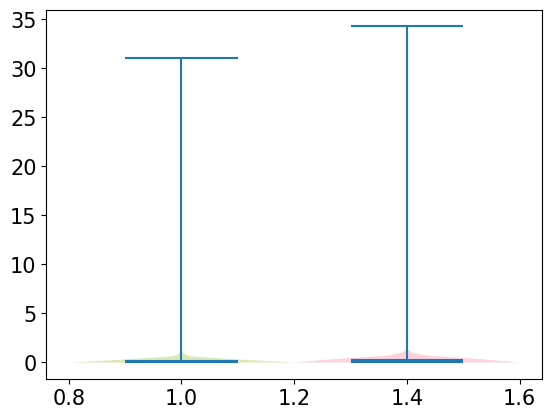

In [74]:
def get_surps(cols):
    ur_surps = []
    g_surps = []
    for col in cols:
        f = pd.read_csv(f'/mnt/align4_drive/arunas/broca/mistral/experiments/10-strip/{col}.csv')
        if ('-u-' in col):
            for idx, row in f[(f['type'] == col) & (f['gold'] == 'Yes')].iterrows():
                myList = []
                for i in list(ast.literal_eval(row['surprisal'])):
                    myList.append(i[1])
                ur_surps.append(myList)
        else:
            for idx, row in f[(f['type'] == col) & (f['gold'] == 'Yes')].iterrows():
                myList = []
                for i in list(ast.literal_eval(row['surprisal'])):
                    myList.append(i[1])
                g_surps.append(myList)
    allg_surps = np.array([i for s in g_surps for i in s])
    allug_surps = np.array([i for s in ur_surps for i in s])
    return sorted(allg_surps), sorted(allug_surps)

en_real, en_unreal = get_surps(['en', 'en-r-1-subordinate', 'en-r-2-passive', 'en-u-1-negation', 'en-u-2-inversion', 'en-u-4-wh'])
ita_real, ita_unreal = get_surps(['ita', 'ita-r-2-subordinate', 'ita-r-3-passive', 'ita-u-1-negation', 'ita-u-2-invert', 'ita-u-3-gender'])
jap_real, jap_unreal = get_surps(['jap-r-1-sov','jap-r-2-passive', 'jap-r-3-subordinate','jap-u-1-negation','jap-u-2-invert', 'jap-u-3-past-tense'])
reals = [en_real, ita_real, jap_real]
unreals = [en_unreal, ita_unreal, jap_unreal]

positions = np.arange(1, len(reals) + 1)

for i in range(len(reals)):
    bp = plt.violinplot([reals[i], unreals[i]], positions=[positions[i], positions[i] + 0.4], 
                widths=0.4, vert=True, showmeans=True)
    for patch, color in zip(bp['bodies'], [colors['Watermelon Green'], colors['Watermelon Pink']]):
        patch.set_facecolor(color)

    bp['cmeans'].set_color(wcolors[i % len(wcolors)])  # Change the color of the mean line
    bp['cmeans'].set_linestyle('-')  # Change the line style of the mean line
    bp['cmeans'].set_linewidth(3)  # Change the line width of the mean line

plt.xlabel("Grammar Type")
plt.xticks(positions + 0.2, ['EN', 'IT', 'JP'], rotation=90)
plt.ylabel("Surprisal")
plt.axvline(x=1.75, color='black', linestyle='--', linewidth=0.5)
plt.axvline(x=2.75, color='black', linestyle='--', linewidth=0.5)

legend_handles = [plt.Rectangle((0,0),1,1, color=colors['Watermelon Green']), plt.Rectangle((0,0),1,1, color=colors['Watermelon Pink'])]
plt.legend(legend_handles, ['Hierarchical', 'Linear'], loc='upper left')

## Top 1% neurons confusion matrix

In [122]:
PREFIX = '/mnt/align4_drive'
component = 0
def conf_matrix(model, compPath, topK, subpath):
    global component
    print('Generating conf matrix')
    og = pd.read_csv(f'{PREFIX}/arunas/broca/data-gen/ngs-new.csv')
    # columns = [col for col in sorted(og.columns) if not 'ng-' in col]
    columns = [col for col in sorted(og.columns) if ('en' in col[:2] or 'jap' in col[:3] or 'ita' in col[:3]) and (not 'qsub' in col) and (not 'null_subject' in col)]
    # columns = [col for col in sorted(columns) if not ('en' in col[:2]) ]
    # columns.remove('jap-u-3-past-tense')
    reals = [col for col in sorted(og.columns) if not '-u-' in col]
    unreals = [col for col in sorted(og.columns) if '-u-' in col]
    component = pd.DataFrame(columns=np.arange(0,65530), index=sorted(columns))
    for col in sorted(columns):
        try:
            with open(f'{PREFIX}/arunas/broca/{model}/atp/patches/{compPath}/{subpath}/{col}.pkl', 'rb') as f:
                component_cache = pickle.load(f)
                component_cache = component_cache.cpu()
                flattened_effects_cache = component_cache.view(-1)
                top_neurons = flattened_effects_cache.topk(k=int(topK * flattened_effects_cache.shape[-1]))
                two_d_indices = torch.cat((((top_neurons[1] // component_cache.shape[1]).unsqueeze(1)), ((top_neurons[1] % component_cache.shape[1]).unsqueeze(1))), dim=1)            
                df = pd.DataFrame(two_d_indices, columns=['layer', 'neuron'])
                for idx, row in df.iterrows():
                    component.loc[(component.index==col),idx] = ",".join([str(row['layer']), str(row['neuron'])])
        except:
            print(col)
    print(idx)
    print('Gathered pickles')
    component = component[list(component.columns)[:idx]]
    fig_column_order = [col for col in component.index if not '-u-' in col] + [col for col in component.index if '-u-' in col]
    component_overlap = pd.DataFrame(columns=fig_column_order, index=fig_column_order)

    
    for col in tqdm(fig_column_order):
        for col1 in fig_column_order:
            component_overlap.loc[(component_overlap.index == col), col1] = len(set(component.loc[col]).intersection(set(component.loc[col1])))/len(component.columns)
        component_overlap[col] = component_overlap[col].astype(float)
    print('Generating chart')
    
    plt.figure(figsize=(10, 8))
    plt.imshow(component_overlap, cmap='binary', aspect='auto', interpolation='nearest')
    ax = plt.gca()
    plt.xticks(range(len(fig_column_order)), labels=[new_names[col] for col in fig_column_order])
    # if (compPath == 'attn'):
    plt.yticks(range(len(sorted(component_overlap.index))), labels=[new_names[col] for col in fig_column_order])
    plt.xticks(fontsize=12, rotation=-45, ha='left')  # Set x-axis tick label font size
    plt.yticks(fontsize=12)  # Set y-axis tick label font size

    cbar = plt.colorbar()
    cbar.set_label('Overlap %', fontsize=15)
    cbar.ax.tick_params(labelsize=15) 
    
    plt.title(f'{model.title()} {compPath.title()}', fontsize=15)
    plt.tight_layout()

    # -------------------------------- Draw lines -------------------------------------------------
    if model == 'llama':
        real_color = '#007FFF'
        unreal_color = '#E55451'
    elif model == 'mistral':
        real_color = '#87CEFA'
        unreal_color = '#FFB6A0'
    sortCols = fig_column_order
    # real_xticks = [(idx+0.5, col) for idx, col in enumerate(sortCols[:-1]) if '-u-' in sortCols[idx+1] and '-r-' in col]
    # unreal_xticks = [ (idx+0.5, col) for idx, col in enumerate(sortCols) if ('it-u-3-' in col ) or ('ita-u-3-' in col ) or ('jp-u-3-' in col) or ('jap-u-2-' in col) or ('en-u-4' in col) ]
    
    # for rx_tick, ux_tick in zip(real_xticks, unreal_xticks):
    #     plt.axvline(x=rx_tick[0], color=real_color)
    #     plt.axvline(x=ux_tick[0], color=unreal_color)
    #     plt.axhline(y=rx_tick[0], color=real_color)
    #     plt.axhline(y=ux_tick[0], color=unreal_color)
        
    # counts =  [ {'r': 3, 'u':3}, {'r': 4, 'u':3}, {'r': 4, 'u':3}, {'r': 2, 'u':2}, {'r': 3, 'u':3}]
                #en               #it              #ita             #jap            #jp
    # counts =  [ {'r': 3, 'u': 3}, {'r': 3, 'u': 3}, {'r': 3, 'u': 3}]
                #en               #ita             #jap
    # counts =  [ {'r': 3, 'u':3}, {'r': 4, 'u':3}, {'r': 3, 'u':3}]
    # #             #en               #it           #jp
    # counts =  [{'r': 4, 'u':3}, {'r': 4, 'u':3}, {'r': 2, 'u':2}, {'r': 3, 'u':3}]
    #            #it              #ita             #jap            #jp
    # for lid in range(len(counts)):
    #     for lid1 in range(len(counts)):
    
    #         x = sum([ l['r'] for li, l in enumerate(counts) if li < lid]) + sum([ l['u'] for li, l in enumerate(counts) if li < lid])
    #         y = sum([ l['r'] for li, l in enumerate(counts) if li < lid1]) + sum([ l['u'] for li, l in enumerate(counts) if li < lid1])
            
    #         width = counts[lid]['r']
    #         height = counts[lid1]['r']
    #         rect = patches.Rectangle((x - 0.5,y - 0.5), width, height, linewidth=2, facecolor='none', edgecolor=real_color)
    #         ax.add_patch(rect)
    #         rect = patches.Rectangle((x - 0.5,y - 0.5), width, height, linewidth=0.5, facecolor='none', edgecolor='black', linestyle='--')
    #         ax.add_patch(rect)
            
    #         x = sum([ l['u'] for li, l in enumerate(counts) if li < lid]) + sum([ l['r'] for li, l in enumerate(counts) if li < lid]) + counts[lid]['r']
    #         y = sum([ l['u'] for li, l in enumerate(counts) if li < lid1]) + sum([ l['r'] for li, l in enumerate(counts) if li < lid1]) + counts[lid1]['r']
            
    #         width = counts[lid]['u']
    #         height = counts[lid1]['u']
    #         rect = patches.Rectangle((x - 0.5,y - 0.5), width, height, linewidth=2, facecolor='none', edgecolor=unreal_color)
    #         ax.add_patch(rect)
    #         rect = patches.Rectangle((x - 0.5,y - 0.5), width, height, linewidth=0.5, facecolor='none', edgecolor='black', linestyle='--')
    #         ax.add_patch(rect)
    #         # print(x, y, width, height)
    #         # rect = patches.Rectangle((x - 0.5,y - 0.5), width, height, linewidth=5, facecolor=(0.24, 0.70, 0.44, 0.2))
    #         ax.add_patch(rect)

    plt.axvline(x=8.5, color='black')
    # plt.axvline(x=ux_tick[0], color=unreal_color)
    plt.axhline(y=8.5, color='black')
    # plt.axhline(y=ux_tick[0], color=unreal_color)
    plt.savefig(f'{model}-{compPath}-overlap-{topK}.png')
    plt.show()
    return component_overlap

Generating conf matrix
1309
Gathered pickles


100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 99.36it/s]

Generating chart


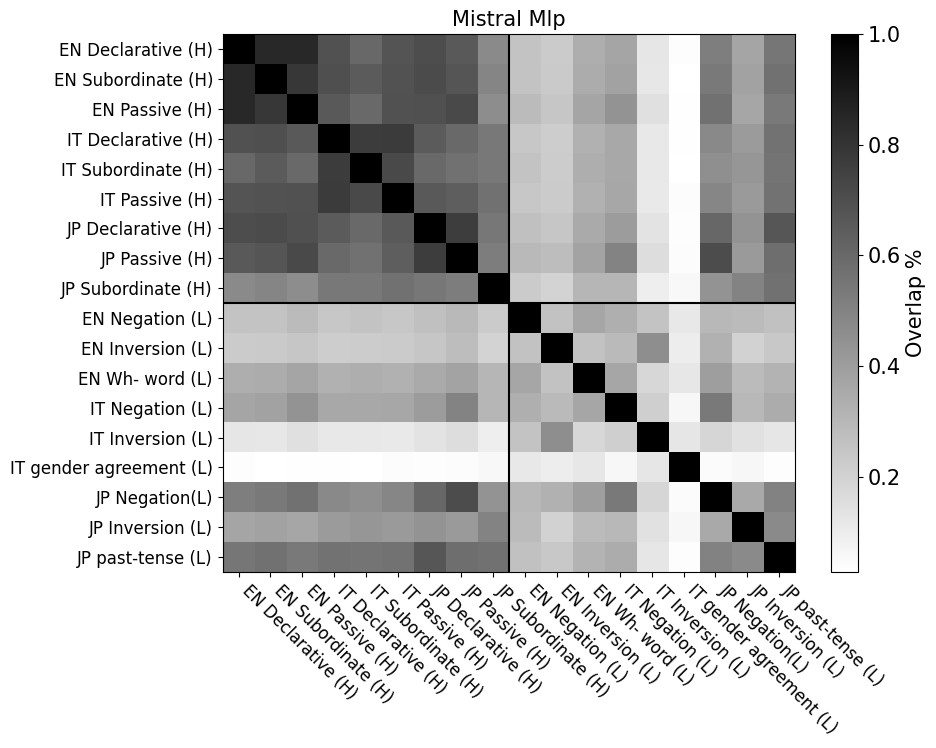

Generating conf matrix
1309
Gathered pickles


100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 112.35it/s]

Generating chart


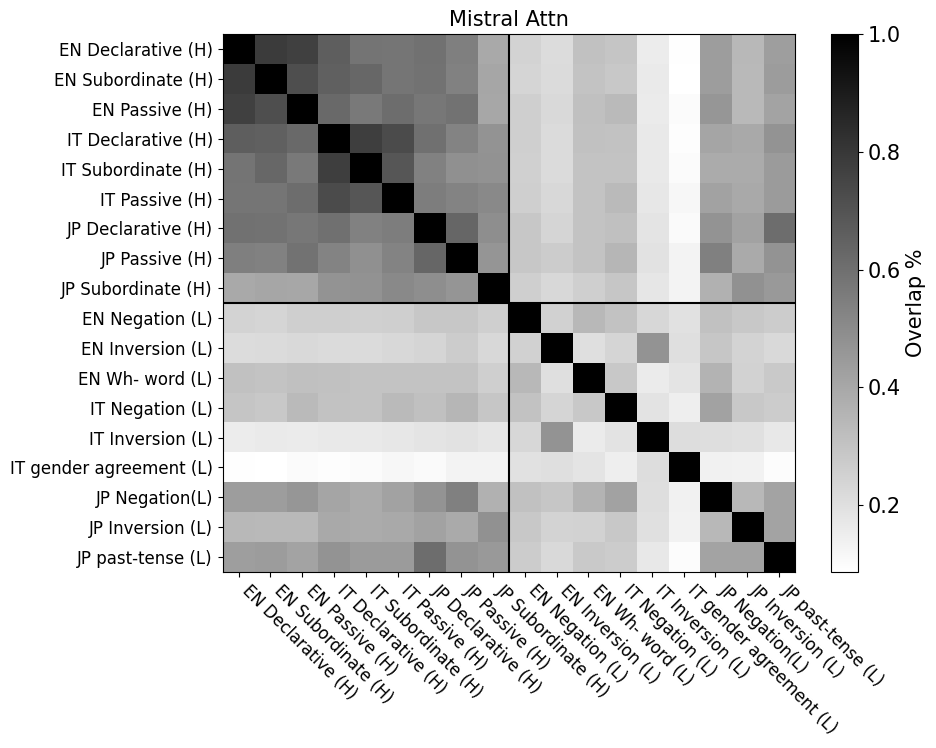

Generating conf matrix
6552
Gathered pickles


100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 23.74it/s]


Generating chart


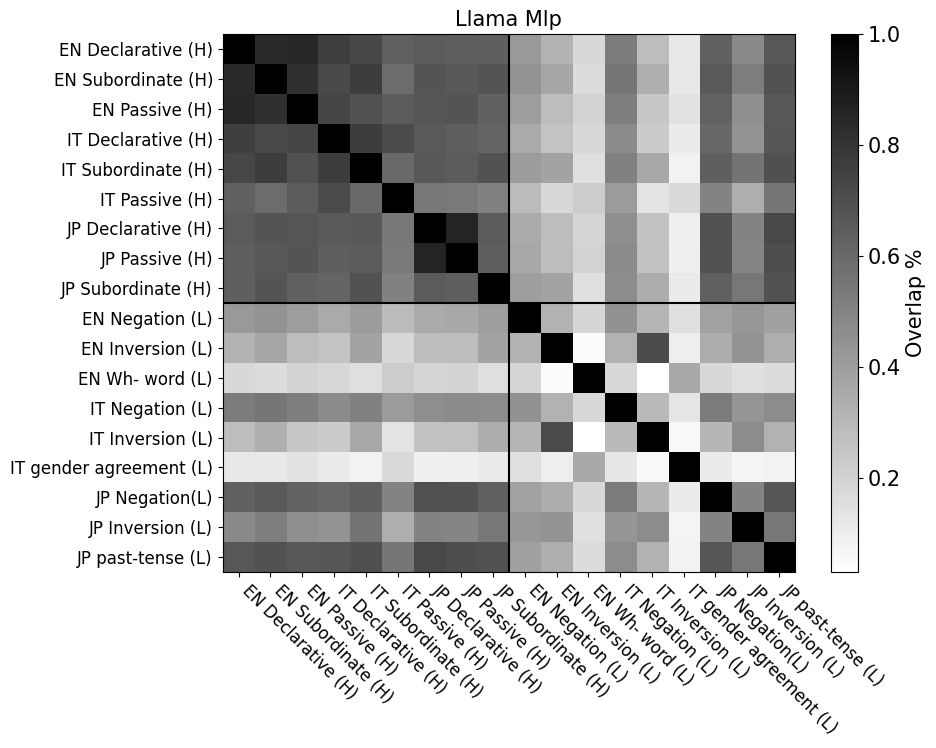

Generating conf matrix
6552
Gathered pickles


100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00, 17.85it/s]


Generating chart


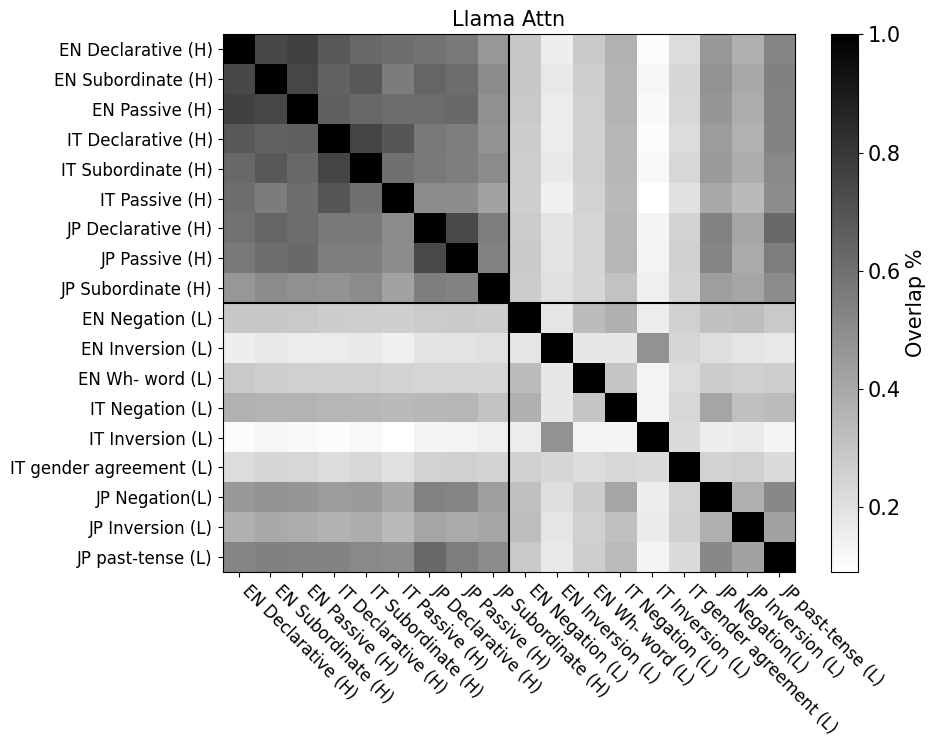

In [123]:
# # conf_matrix('llama', 'attn', 0.01, 'all-neurons-new-prompt-prologue-random-seed')
# # conf_matrix('llama', 'mlp', 0.01, 'all-neurons-new-prompt-prologue-random-seed')
# # old_mlp = conf_matrix('mistral', 'mlp', 0.01, 'old/all-neurons-new-prompt-prologue-random-seed')
# # old_attn = conf_matrix('mistral', 'attn', 0.01, 'old/all-neurons-new-prompt-prologue-random-seed')

new_mlp = conf_matrix('mistral', 'mlp', 0.01, '10-strip')
new_attn = conf_matrix('mistral', 'attn', 0.01, '10-strip')

new_mlp = conf_matrix('llama', 'mlp', 0.01, '10')
new_attn = conf_matrix('llama', 'attn', 0.01, '10')

In [102]:
def get_overlaps(component):
    reals = { 'en': [], 'ita': [], 'jap': [] }
    unreals = { 'en': [], 'ita': [], 'jap': [] }
    reals_unreals = { 'en': [], 'ita': [], 'jap': [] }
    for ind in component.index:
        for col in component.columns:
            # print(ind, col)
            if (not '-u-' in col) and (not '-u-' in ind):
                if ('en' in col[:2]) and ('en' in ind[:2]):
                    reals['en'].append(component[(component.index == ind)][col].item())
                elif ('ita' in col[:3]) and ('ita' in ind[:3]):
                    reals['ita'].append(component[(component.index == ind)][col].item())
                elif ('jap' in col[:3]) and ('jap' in ind[:3]):
                    reals['jap'].append(component[(component.index == ind)][col].item())
            elif ('-u-' in col) and ('-u-' in ind):
                if ('en' in col[:2]) and ('en' in ind[:2]):
                    unreals['en'].append(component[(component.index == ind)][col].item())
                elif ('ita' in col[:3]) and ('ita' in ind[:3]):
                    unreals['ita'].append(component[(component.index == ind)][col].item())
                elif ('jap' in col[:3]) and ('jap' in ind[:3]):
                    unreals['jap'].append(component[(component.index == ind)][col].item())
            elif ('-u-' in col) and ('-r-' in ind):
                if ('en' in col[:2]) and ('en' in ind[:2]):
                    reals_unreals['en'].append(component[(component.index == ind)][col].item())
                elif ('ita' in col[:3]) and ('ita' in ind[:3]):
                    reals_unreals['ita'].append(component[(component.index == ind)][col].item())
                elif ('jap' in col[:3]) and ('jap' in ind[:3]):
                    reals_unreals['jap'].append(component[(component.index == ind)][col].item())

    t_reals = [val for key in reals.keys() for val in reals[key]]
    t_unreals = [val for key in reals.keys() for val in unreals[key]]
    t_reals_unreals = [val for key in reals.keys() for val in reals_unreals[key]]
    print('H-H vs L-L', stats.mannwhitneyu(t_reals, t_unreals))
    print('H-H vs H-L', stats.mannwhitneyu(t_reals, t_reals_unreals))
    print('L-L vs H-L', stats.mannwhitneyu(t_unreals, t_reals_unreals))
    return reals, unreals, reals_unreals

MLP
H-H vs L-L MannwhitneyuResult(statistic=514.5, pvalue=0.0083787224461972)
H-H vs H-L MannwhitneyuResult(statistic=533.0, pvalue=2.0682805559687992e-07)
L-L vs H-L MannwhitneyuResult(statistic=309.0, pvalue=0.6020916709185172)
['en', 'ita', 'jap']
[0.8897368064034731, 0.7950074616741284, 0.8127798127798128] [0.4565187898521232, 0.43928910595577264, 0.7147605480938815] [0.30797212047212047, 0.27866809116809116, 0.6293752543752544]


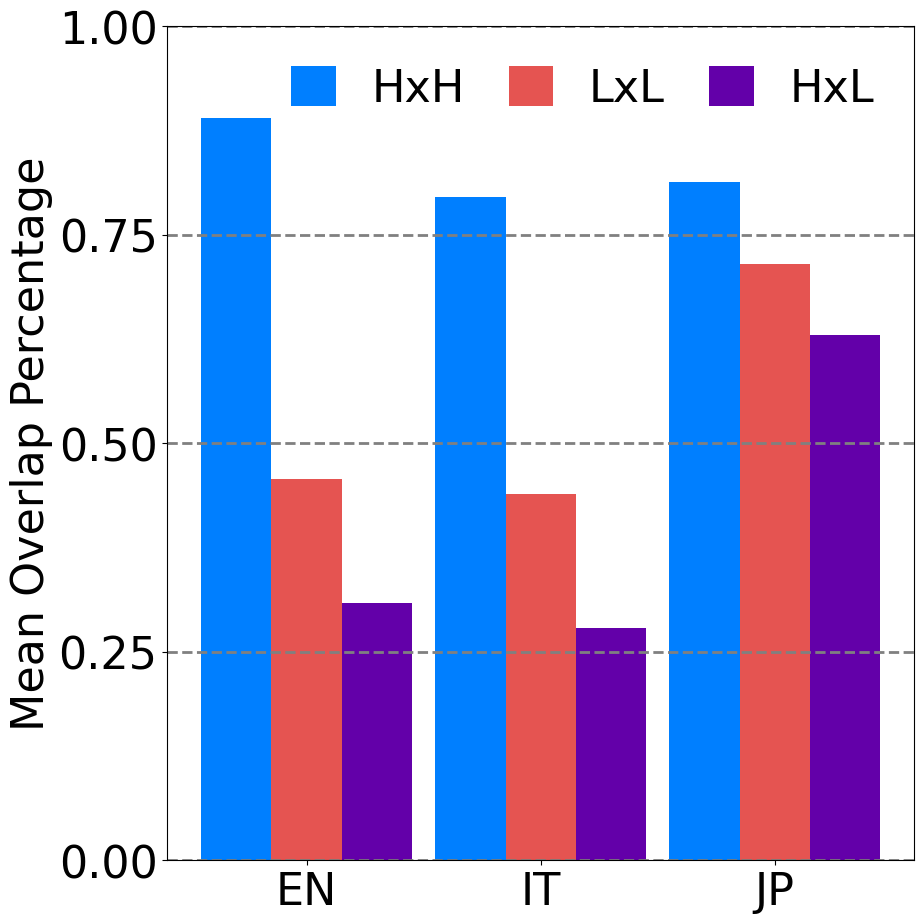

Attn
H-H vs L-L MannwhitneyuResult(statistic=526.5, pvalue=0.004399030196889586)
H-H vs H-L MannwhitneyuResult(statistic=555.0, pvalue=1.586643093235654e-08)
L-L vs H-L MannwhitneyuResult(statistic=337.0, pvalue=0.26900480387397374)
['en', 'ita', 'jap']
[0.8351987518654186, 0.7886650386650387, 0.7375186541853208] [0.48690815357482026, 0.46316646316646315, 0.6252543752543752] [0.23842592592592593, 0.22067053317053317, 0.48836657169990505]


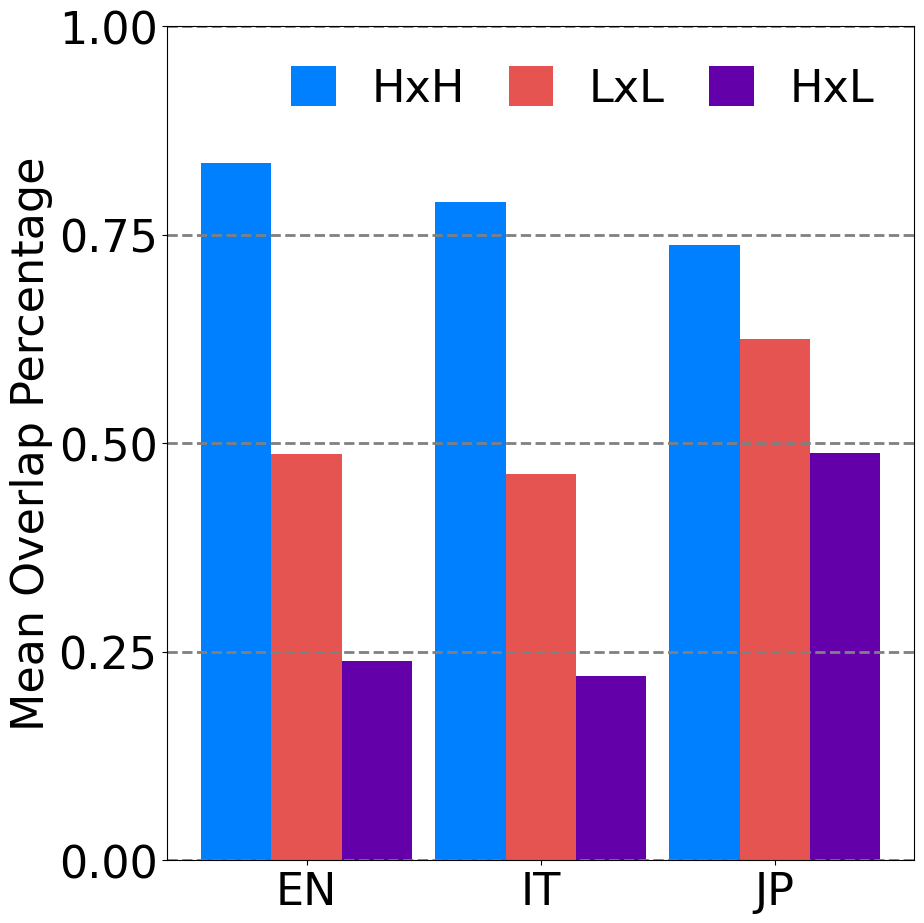

In [108]:
plt.rcParams.update({'font.size': 32})
def draw_plot(component):
    # Extract the categories and the values
    if component == 'MLP':
        print('MLP')
        reals, unreals, reals_unreals = get_overlaps(new_mlp)
    else:
        print('Attn')
        reals, unreals, reals_unreals = get_overlaps(new_attn)
    categories = list(reals.keys())
    print(categories)
    set1_counts = [statistics.mean(reals[category]) for category in categories]
    set2_counts = [statistics.mean(unreals[category]) for category in categories]
    set3_counts = [statistics.mean(reals_unreals[category]) for category in categories]
    print(set1_counts, set2_counts, set3_counts)
    # Number of categories
    num_categories = len(categories)
    
    # Create bar plot
    fig, ax = plt.subplots(figsize=(10, 10))
    
    bar_width = 0.3
    index = np.arange(num_categories)
    
    bars1 = ax.bar(index - bar_width, set1_counts, bar_width, label='HxH', color=real_color)
    bars2 = ax.bar(index, set2_counts, bar_width, label='LxL', color=unreal_color)
    bars3 = ax.bar(index + bar_width, set3_counts, bar_width, label='HxL', color=mixed_color)
    
    # Add labels, title, and legend
    plt.grid(True, which='major', axis='y', linestyle='--', linewidth=2, color='gray', alpha=1)
    # ax.set_xlabel('Language')
    ax.set_ylabel(f'Mean Overlap Percentage')
    # ax.set_title(f'{component} overlaps', fontsize=21)
    ax.set_xticks(index)
    ax.set_yticks([0,0.25,0.5, 0.75,1])
    # ax.set_xticklabels(['en-ita', 'ita-jap', 'jap-en'])
    ax.set_xticklabels(['EN', 'IT', 'JP'])
    ax.legend(ncol=3, handlelength=1, handleheight=1, columnspacing=1, frameon=False)
    plt.tight_layout()
    plt.savefig(f'llama-mean-{component}-overlaps.png')
    # Display the plot
    plt.show()

draw_plot('MLP')
draw_plot('Attn')

In [104]:
!pwd

/mnt/align4_drive/arunas/broca/mistral/atp


## Mean ablation results

In [129]:
mistral_ablations['lang']

0                      en
1      en-r-1-subordinate
2          en-r-2-passive
3         en-u-1-negation
4        en-u-2-inversion
5               en-u-4-wh
6                     ita
7     ita-r-2-subordinate
8         ita-r-3-passive
9        ita-u-1-negation
10         ita-u-2-invert
11         ita-u-3-gender
12            jap-r-1-sov
13        jap-r-2-passive
14    jap-r-3-subordinate
15       jap-u-1-negation
16         jap-u-2-invert
17     jap-u-3-past-tense
Name: lang, dtype: object

<>:69: SyntaxWarning: invalid escape sequence '\D'
<>:69: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_2500922/1380834398.py:69: SyntaxWarning: invalid escape sequence '\D'
  ax.set_ylabel('$\Delta\quadAccuracy$')


REAL ABLATIONS: H-U MannwhitneyuResult(statistic=16.5, pvalue=0.037778906339199746)
UNREAL ABLATIONS: H-U MannwhitneyuResult(statistic=40.0, pvalue=1.0)
RANDOM ABLATIONS: H-U MannwhitneyuResult(statistic=54.5, pvalue=0.23202193955139572)
6 6
6
6
6


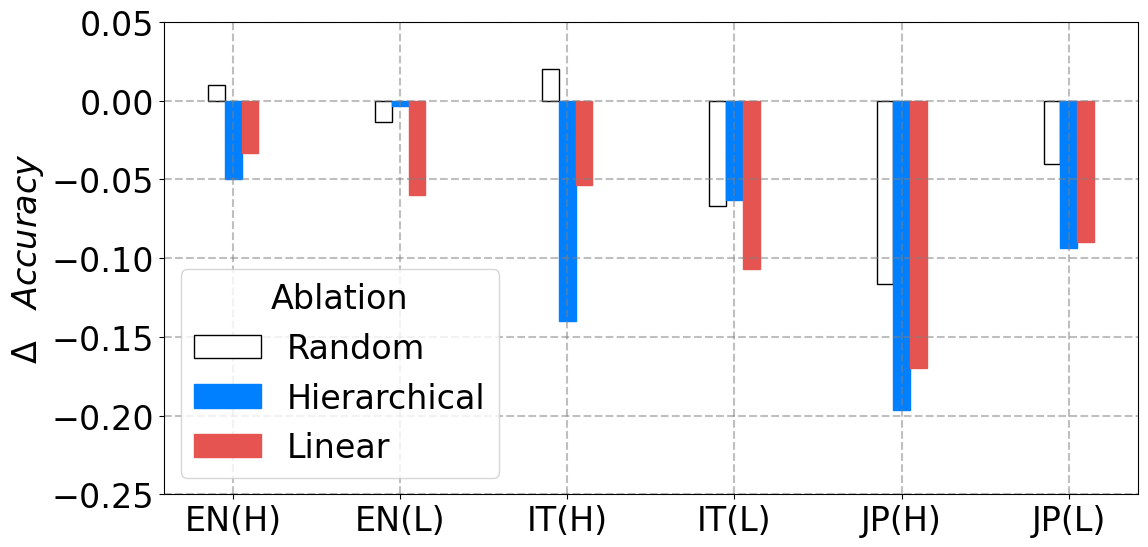

In [138]:
# Sample data
mistral_ablations = pd.read_csv('/mnt/align4_drive/arunas/broca/mistral/experiments/10-strip/ablations.csv')
mistral_ablations['real'] = mistral_ablations.apply(lambda row:row['real'] - row['none'], axis=1)
mistral_ablations['unreal'] = mistral_ablations.apply(lambda row:row['unreal'] - row['none'], axis=1)
mistral_ablations['random'] = mistral_ablations.apply(lambda row:row['random'] - row['none'], axis=1)

print('REAL ABLATIONS: H-U', stats.mannwhitneyu(mistral_ablations[~mistral_ablations['lang'].str.contains('-u-')]['real'], mistral_ablations[mistral_ablations['lang'].str.contains('-u-')]['real']))
print('UNREAL ABLATIONS: H-U', stats.mannwhitneyu(mistral_ablations[~mistral_ablations['lang'].str.contains('-u-')]['unreal'], mistral_ablations[mistral_ablations['lang'].str.contains('-u-')]['unreal']))
print('RANDOM ABLATIONS: H-U', stats.mannwhitneyu(mistral_ablations[~mistral_ablations['lang'].str.contains('-u-')]['random'], mistral_ablations[mistral_ablations['lang'].str.contains('-u-')]['random']))
# print('H-R', stats.ttest_rel(mistral_ablations['real'], mistral_ablations['random']))
# print('R-U', stats.ttest_rel(mistral_ablations['random'], mistral_ablations['unreal']))
plt.rcParams.update({'font.size': 24})
lang = ['EN', 'ITA', 'JAP']
mistral_ablations_H_H = [statistics.mean(list(mistral_ablations[mistral_ablations['lang'].isin(filter(lambda val: l.lower() in val[:len(l)] if not '-u-' in val else 0, list(mistral_ablations['lang'])))]['real'])) for l in lang]
mistral_ablations_H_L = [statistics.mean(list(mistral_ablations[mistral_ablations['lang'].isin(filter(lambda val: l.lower() in val[:len(l)] if '-u-' in val else 0, list(mistral_ablations['lang'])))]['real'])) for l in lang]
mistral_ablations_L_H = [statistics.mean(list(mistral_ablations[mistral_ablations['lang'].isin(filter(lambda val: l.lower() in val[:len(l)] if not '-u-' in val else 0, list(mistral_ablations['lang'])))]['unreal'])) for l in lang]
mistral_ablations_L_L = [statistics.mean(list(mistral_ablations[mistral_ablations['lang'].isin(filter(lambda val: l.lower() in val[:len(l)] if '-u-' in val else 0, list(mistral_ablations['lang'])))]['unreal'])) for l in lang]
mistral_ablations_randoms_H = [statistics.mean(list(mistral_ablations[mistral_ablations['lang'].isin(filter(lambda val: l.lower() in val[:len(l)] if not '-u-' in val else 0, list(mistral_ablations['lang'])))]['random'])) for l in lang]
mistral_ablations_randoms_L = [statistics.mean(list(mistral_ablations[mistral_ablations['lang'].isin(filter(lambda val: l.lower() in val[:len(l)] if '-u-' in val else 0, list(mistral_ablations['lang'])))]['random'])) for l in lang]
# mistral_ablations_none_H = [statistics.mean(list(mistral_ablations[mistral_ablations['lang'].isin(filter(lambda val: l.lower() in val[:len(l)] if not '-u-' in val else 0, list(mistral_ablations['lang'])))]['none'])) for l in lang] 
# mistral_ablations_none_L = [statistics.mean(list(mistral_ablations[mistral_ablations['lang'].isin(filter(lambda val: l.lower() in val[:len(l)] if '-u-' in val else 0, list(mistral_ablations['lang'])))]['none'])) for l in lang] 

lang = ['EN(H)', 'EN(L)', 'IT(H)', 'IT(L)', 'JP(H)', 'JP(L)']
data = {
    'HabH': mistral_ablations_H_H,
    'HabL': mistral_ablations_H_L,
    'LabH': mistral_ablations_L_H,
    'LabL': mistral_ablations_L_L,
    'RabH': mistral_ablations_randoms_H,
    'RabL': mistral_ablations_randoms_L,
    # 'H': mistral_ablations_none_H,
    # 'L': mistral_ablations_none_L
}

data = {
    'R': [data['RabH'][0], data['RabL'][0], data['RabH'][1], data['RabL'][1], data['RabH'][2], data['RabL'][2]],
    'H': [data['HabH'][0], data['HabL'][0], data['HabH'][1], data['HabL'][1], data['HabH'][2], data['HabL'][2]],
    'L': [data['LabH'][0], data['LabL'][0], data['LabH'][1], data['LabL'][1], data['LabH'][2], data['LabL'][2]]
}
unreal_gradients = ["#FF6347", "#FF4500", "#DC143C", "#B22222", "#8B0000"]
real_gradients = ["#1E90FF", "#4169E1", "#0000FF", "#0000CD", "#00008B"]
bar_labels = ['Random', 'Hierarchical', 'Linear']
hatch_pattern = '...'
base_bar_colors    = [ 'white', real_color, unreal_color ]
overlay_colors    = [ 'black',  real_color, unreal_color ]
hatch_pattern = ['+', '+', '/', '/', '', '']
# Number of lang and bars per category
n_categories = len(lang)
n_bars = len(lang)

# Positions of the bars on the x-axis
bar_width = 0.1  # Width of each bar
category_positions = np.arange(n_categories)
bar_positions = [category_positions + bar_width * i for i in range(n_bars)]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))
print(len(bar_positions), len(category_positions))
# Plotting the bars
for i, key in enumerate(['R', 'H', 'L']):
    values = data[key]
    print(len(data[key]))
    ax.bar(bar_positions[i], values, width=bar_width, label=bar_labels[i], color=base_bar_colors[i], edgecolor=overlay_colors[i], linewidth=1)


# Adding labels and title
# ax.axhline(y='0', linewidth=2, color='gray')
# ax.set_xlabel('Language')
ax.set_ylabel('$\Delta\quadAccuracy$')
# ax.set_title('Mean ablation results')
ax.set_xticks(category_positions + bar_width)
ax.set_xticklabels(lang)
ax.set_ylim(-0.25,0.05)
# ax.set_ylim(-1,0.1)

plt.grid(True, which='major', linestyle='--', linewidth=1.5, color='gray', alpha=0.5)
ax.legend(title='Ablation')
# Adjust layout to make space for the legend
plt.tight_layout()
plt.savefig(f'mistral-mean-ablations.png')
# Show the plot
plt.show()


In [532]:
mistral_ablations['real - unreal'] = mistral_ablations.apply(lambda row: row['real'] - row['unreal'], axis=1)

In [533]:
mistral_ablations

,none,real,unreal,random,lang,real - unreal
0,0.93,-0.07,-0.06,-0.01,en,-0.01
1,0.89,-0.03,-0.01,0.02,en-r-1-subordinate,-0.02
2,0.93,-0.05,-0.03,0.02,en-r-2-passive,-0.02
3,0.62,0.03,-0.08,0.00,en-u-1-negation,0.11
4,0.63,-0.03,-0.03,-0.05,en-u-2-inversion,0.00
5,0.62,-0.01,-0.07,0.01,en-u-4-wh,0.06
6,0.83,-0.14,-0.05,0.03,ita,-0.09
7,0.78,-0.13,-0.06,0.03,ita-r-2-subordinate,-0.07
8,0.83,-0.15,-0.05,0.00,ita-r-3-passive,-0.10
9,0.86,-0.17,-0.28,-0.17,ita-u-1-negation,0.11


<>:68: SyntaxWarning: invalid escape sequence '\D'
<>:68: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_2500922/3109396526.py:68: SyntaxWarning: invalid escape sequence '\D'
  ax.set_ylabel('$\Delta\quadAccuracy$')


REAL ABLATIONS: H-U MannwhitneyuResult(statistic=42.0, pvalue=0.9278701596257053)
UNREAL ABLATIONS: H-U MannwhitneyuResult(statistic=30.5, pvalue=0.3928592820751241)
RANDOM ABLATIONS: H-U MannwhitneyuResult(statistic=33.0, pvalue=0.5242620054050413)
6 6
6
6
6


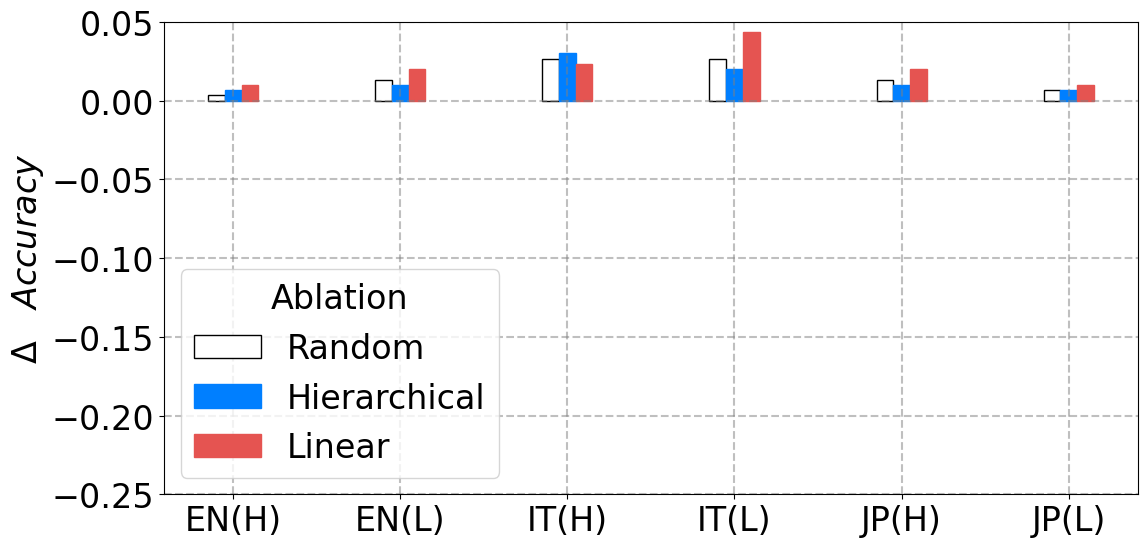

In [139]:
# Sample data
llama_ablations = pd.read_csv('/mnt/align4_drive/arunas/broca/llama/experiments/10/ablations.csv')
llama_ablations['real'] = llama_ablations.apply(lambda row:row['real'] - row['none'], axis=1)
llama_ablations['unreal'] = llama_ablations.apply(lambda row:row['unreal'] - row['none'], axis=1)
llama_ablations['random'] = llama_ablations.apply(lambda row:row['random'] - row['none'], axis=1)

print('REAL ABLATIONS: H-U', stats.mannwhitneyu(llama_ablations[~llama_ablations['lang'].str.contains('-u-')]['real'], llama_ablations[llama_ablations['lang'].str.contains('-u-')]['real']))
print('UNREAL ABLATIONS: H-U', stats.mannwhitneyu(llama_ablations[~llama_ablations['lang'].str.contains('-u-')]['unreal'], llama_ablations[llama_ablations['lang'].str.contains('-u-')]['unreal']))
print('RANDOM ABLATIONS: H-U', stats.mannwhitneyu(llama_ablations[~llama_ablations['lang'].str.contains('-u-')]['random'], llama_ablations[llama_ablations['lang'].str.contains('-u-')]['random']))

plt.rcParams.update({'font.size': 24})
lang = ['EN', 'ITA', 'JAP']
llama_ablations_H_H = [statistics.mean(list(llama_ablations[llama_ablations['lang'].isin(filter(lambda val: l.lower() in val[:len(l)] if not '-u-' in val else 0, list(llama_ablations['lang'])))]['real'])) for l in lang]
llama_ablations_H_L = [statistics.mean(list(llama_ablations[llama_ablations['lang'].isin(filter(lambda val: l.lower() in val[:len(l)] if '-u-' in val else 0, list(llama_ablations['lang'])))]['real'])) for l in lang]
llama_ablations_L_H = [statistics.mean(list(llama_ablations[llama_ablations['lang'].isin(filter(lambda val: l.lower() in val[:len(l)] if not '-u-' in val else 0, list(llama_ablations['lang'])))]['unreal'])) for l in lang]
llama_ablations_L_L = [statistics.mean(list(llama_ablations[llama_ablations['lang'].isin(filter(lambda val: l.lower() in val[:len(l)] if '-u-' in val else 0, list(llama_ablations['lang'])))]['unreal'])) for l in lang]
llama_ablations_randoms_H = [statistics.mean(list(llama_ablations[llama_ablations['lang'].isin(filter(lambda val: l.lower() in val[:len(l)] if not '-u-' in val else 0, list(llama_ablations['lang'])))]['random'])) for l in lang]
llama_ablations_randoms_L = [statistics.mean(list(llama_ablations[llama_ablations['lang'].isin(filter(lambda val: l.lower() in val[:len(l)] if '-u-' in val else 0, list(llama_ablations['lang'])))]['random'])) for l in lang]
# llama_ablations_none_H = [statistics.mean(list(llama_ablations[llama_ablations['lang'].isin(filter(lambda val: l.lower() in val[:len(l)] if not '-u-' in val else 0, list(llama_ablations['lang'])))]['none'])) for l in lang] 
# llama_ablations_none_L = [statistics.mean(list(llama_ablations[llama_ablations['lang'].isin(filter(lambda val: l.lower() in val[:len(l)] if '-u-' in val else 0, list(llama_ablations['lang'])))]['none'])) for l in lang] 

lang = ['EN(H)', 'EN(L)', 'IT(H)', 'IT(L)', 'JP(H)', 'JP(L)']
data = {
    'HabH': llama_ablations_H_H,
    'HabL': llama_ablations_H_L,
    'LabH': llama_ablations_L_H,
    'LabL': llama_ablations_L_L,
    'RabH': llama_ablations_randoms_H,
    'RabL': llama_ablations_randoms_L,
    # 'H': llama_ablations_none_H,
    # 'L': llama_ablations_none_L
}

data = {
    'R': [data['RabH'][0], data['RabL'][0], data['RabH'][1], data['RabL'][1], data['RabH'][2], data['RabL'][2]],
    'H': [data['HabH'][0], data['HabL'][0], data['HabH'][1], data['HabL'][1], data['HabH'][2], data['HabL'][2]],
    'L': [data['LabH'][0], data['LabL'][0], data['LabH'][1], data['LabL'][1], data['LabH'][2], data['LabL'][2]]
}
unreal_gradients = ["#FF6347", "#FF4500", "#DC143C", "#B22222", "#8B0000"]
real_gradients = ["#1E90FF", "#4169E1", "#0000FF", "#0000CD", "#00008B"]
bar_labels = ['Random', 'Hierarchical', 'Linear']
hatch_pattern = '...'
base_bar_colors    = [ 'white', real_color, unreal_color ]
overlay_colors    = [ 'black',  real_color, unreal_color ]
hatch_pattern = ['+', '+', '/', '/', '', '']
# Number of lang and bars per category
n_categories = len(lang)
n_bars = len(lang)

# Positions of the bars on the x-axis
bar_width = 0.1  # Width of each bar
category_positions = np.arange(n_categories)
bar_positions = [category_positions + bar_width * i for i in range(n_bars)]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))
print(len(bar_positions), len(category_positions))
# Plotting the bars
for i, key in enumerate(['R', 'H', 'L']):
    values = data[key]
    print(len(data[key]))
    ax.bar(bar_positions[i], values, width=bar_width, label=bar_labels[i], color=base_bar_colors[i], edgecolor=overlay_colors[i], linewidth=1)


# Adding labels and title
# ax.axhline(y='0', linewidth=2, color='gray')
# ax.set_xlabel('Language')
ax.set_ylabel('$\Delta\quadAccuracy$')
# ax.set_title('Mean ablation results')
ax.set_xticks(category_positions + bar_width)
ax.set_xticklabels(lang)
ax.set_ylim(-0.25,0.05)
# ax.set_ylim(-1,0.1)

plt.grid(True, which='major', linestyle='--', color='gray', linewidth=1.5, alpha=0.5)
ax.legend(title='Ablation')
# Adjust layout to make space for the legend
plt.tight_layout()
plt.savefig(f'llama-mean-ablations.png')
# Show the plot
plt.show()
